# Multilabel Classification with TF-IDF and Naive Bayes

This notebook demonstrates a multilabel text classification task using TF-IDF for feature extraction and Naive Bayes for classification. The dataset used is a CSV file with descriptions and tags.


## Libraries and Dependencies

In [2]:
import pandas as pd
import torch
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score

## Loading the Data
Read the CSV file containing the data.

In [3]:
df=pd.read_csv('en_CTP10_tokenized.csv')
df.head()

,Unnamed: 0,time_limit,memory_limit,description,tags,language,tokenized_description
0,1616/E,1.0,256.0,give two string $$$ s $$$ $$$ t $$$ equal leng...,"['bruteforce', 'datastructures', 'greedy', 'st...",en,"[0, 26650, 80, 6755, 68, 42654, 579, 68, 42654..."
1,900/A,1.0,256.0,n distinct point a plane none lie oy axis chec...,"['geometry', 'implementation']",en,"[0, 282, 11693, 477, 10, 3286, 4146, 6105, 231..."
2,702/F,4.0,1024.0,big consignment t - shirts go sale shop begin ...,['datastructures'],en,"[0, 8527, 7407, 15645, 326, 111, 15331, 213, 1..."
3,181/A,2.0,256.0,berland capital shake three bold crimes commit...,"['bruteforce', 'geometry', 'implementation']",en,"[0, 1943, 1245, 812, 8559, 130, 7457, 3474, 62..."
4,1352/A,1.0,256.0,a positive ( strictly greater zero ) integer c...,"['implementation', 'math']",en,"[0, 102, 1313, 36, 14657, 2388, 4276, 4839, 48..."


## TF-IDF Vectorization
Use `TfidfVectorizer` to convert the text descriptions into numerical features.

In [4]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['description'])
X.shape

(1624, 1000)

## Preprocessing the Tags
Convert the `tags` column from strings to lists.

In [5]:
import ast

tags = df['tags'].tolist()
for i in range(len(tags)):
    tags[i] = str(tags[i])

df['tags'] = [ast.literal_eval(tag) for tag in tags]

## Binarizing the Tags
Use `MultiLabelBinarizer` to convert the tags into a binary format.

In [6]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['tags'])

## Train-Test Split
Split the data into training and testing sets.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training
Train a `MultinomialNB` classifier using `OneVsRestClassifier`.

In [8]:
nb= MultinomialNB()

classifier = OneVsRestClassifier(nb)
classifier.fit(X_train, y_train)

X_train.shape

(1299, 1000)

## Predictions
Make predictions on the test set.

In [9]:
y_pred = classifier.predict(X_test)
y_pred.shape

(325, 10)

Ensure that each text has at least one tag predicted.

In [10]:
for i in range(y_pred.shape[0]):
    if not y_pred[i].any():
        # Assign the most probable tag
        y_pred[i, np.argmax(classifier.predict_proba(X_test[i]))] = 1

## Evaluation
Evaluate the model using various metrics.

In [11]:
report=classification_report(y_test, y_pred, zero_division= 0, target_names=mlb.classes_,output_dict=True)
avgs=['weighted avg', 'macro avg', 'micro avg', 'samples avg']
report_df = pd.DataFrame(report).transpose()

In [12]:
for index_name in avgs:
    row = report_df.loc[index_name]
    print(f"{index_name.capitalize()} Metrics:")
    for metric_name, value in row.items():
        print(f"  {metric_name.capitalize()}: {value:.2f}")
    print()

Weighted avg Metrics:
  Precision: 0.52
  Recall: 0.30
  F1-score: 0.32
  Support: 635.00

Macro avg Metrics:
  Precision: 0.52
  Recall: 0.20
  F1-score: 0.24
  Support: 635.00

Micro avg Metrics:
  Precision: 0.55
  Recall: 0.30
  F1-score: 0.39
  Support: 635.00

Samples avg Metrics:
  Precision: 0.54
  Recall: 0.33
  F1-score: 0.39
  Support: 635.00



In [13]:
report_df.drop(avgs, axis=0, inplace=True)
report_df

,precision,recall,f1-score,support
bruteforce,0.200000,0.016393,0.030303,61.0
constructivealgorithms,0.500000,0.013699,0.026667,73.0
datastructures,1.000000,0.040816,0.078431,49.0
dfsandsimilar,0.000000,0.000000,0.000000,4.0
dp,0.000000,0.000000,0.000000,50.0
geometry,1.000000,0.176471,0.300000,17.0
greedy,0.522727,0.414414,0.462312,111.0
implementation,0.515789,0.690141,0.590361,142.0
math,0.630435,0.287129,0.394558,101.0
strings,0.833333,0.370370,0.512821,27.0


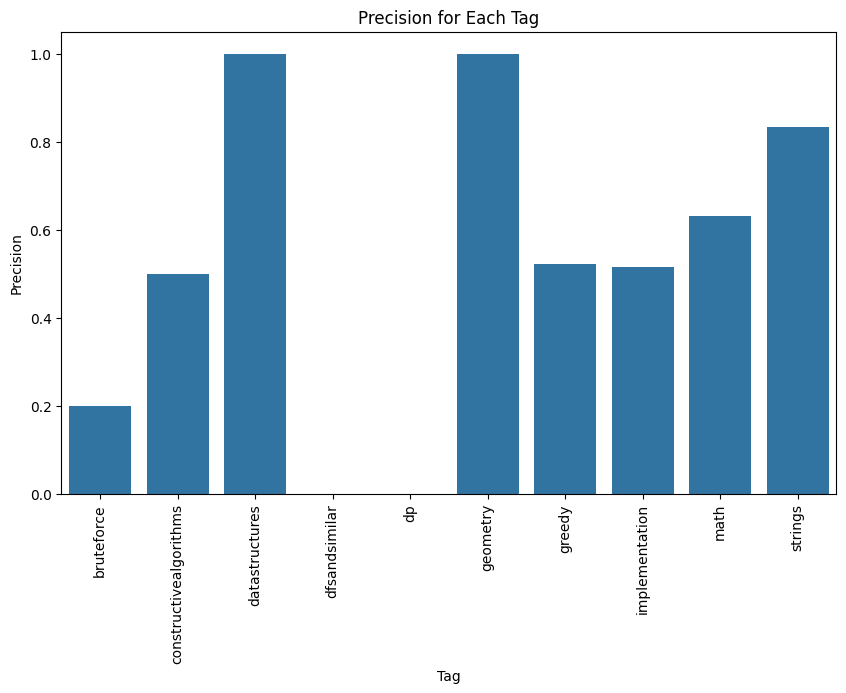

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y='precision', data=report_df)
plt.xticks(rotation=90)
plt.title('Precision for Each Tag')
plt.xlabel('Tag')
plt.ylabel('Precision')
plt.show()

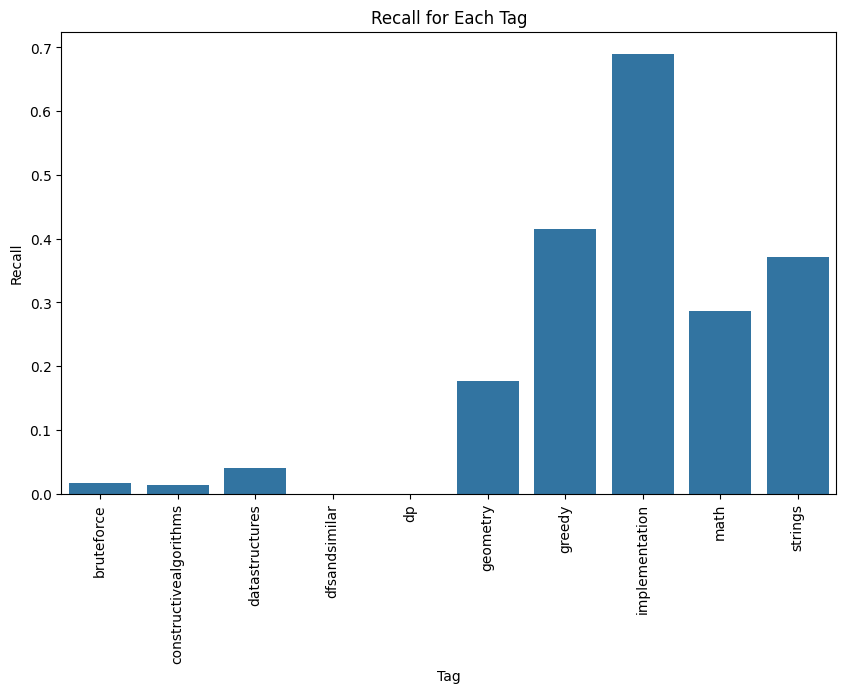

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y='recall', data=report_df)
plt.xticks(rotation=90)
plt.title('Recall for Each Tag')
plt.xlabel('Tag')
plt.ylabel('Recall')
plt.show()

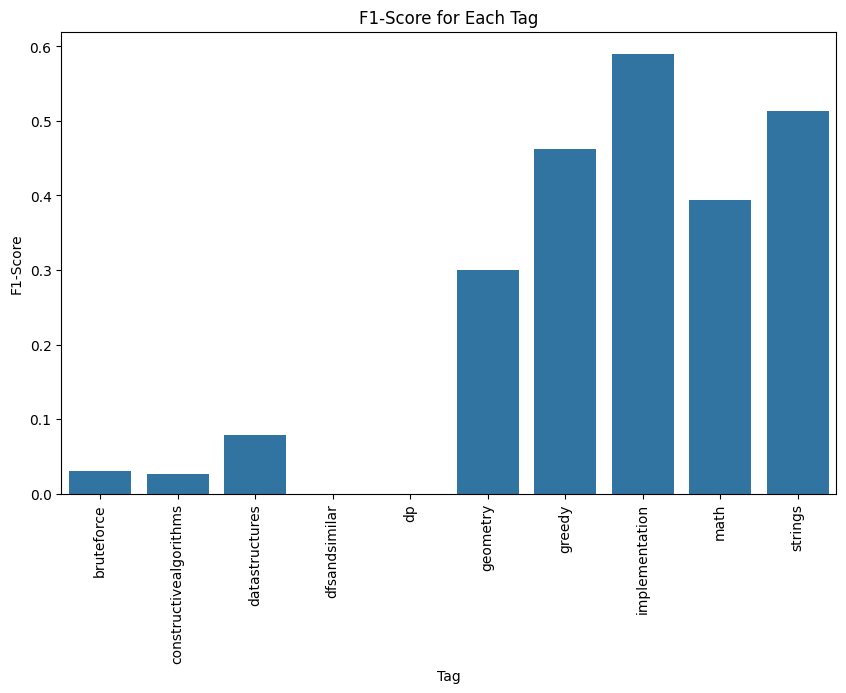

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y='f1-score', data=report_df)
plt.xticks(rotation=90)
plt.title('F1-Score for Each Tag')
plt.xlabel('Tag')
plt.ylabel('F1-Score')
plt.show()

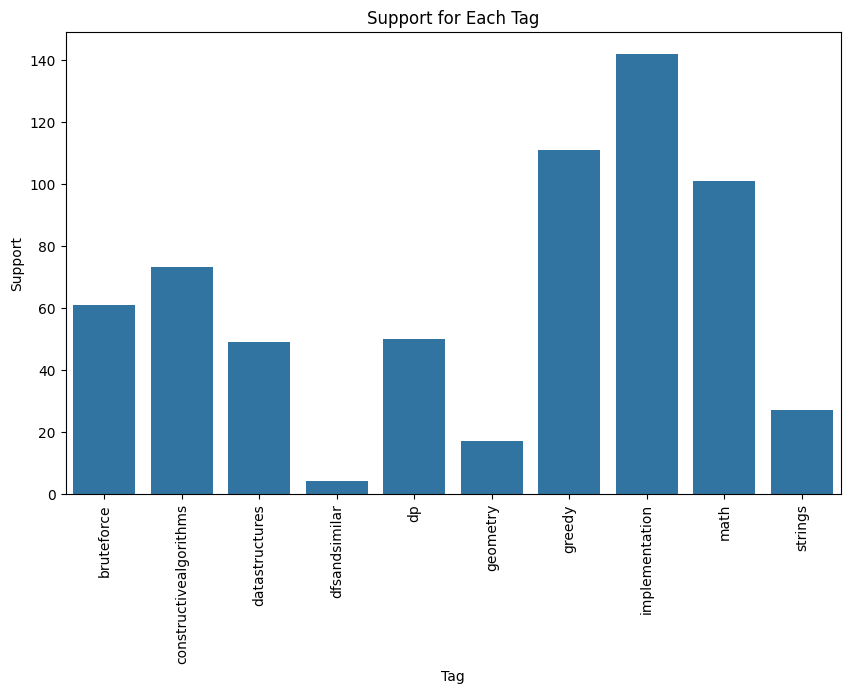

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y='support', data=report_df)
plt.xticks(rotation=90)
plt.title('Support for Each Tag')
plt.xlabel('Tag')
plt.ylabel('Support')
plt.show()

In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

Overall Accuracy: 14.46%


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

dic={}
for i, class_name in enumerate(mlb.classes_):
    dic[class_name]=i

def plot_confusion_matrix(class_name):
    '''
    Plot the confusion matrix for the specified class.
    '''
    cm = confusion_matrix(y_test[:, dic[class_name]], y_pred[:, dic[class_name]])
    labels = ['False', 'True']
    sns.heatmap(cm, annot=True, fmt='d',xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.show()


# Plot confusion matrix for each class
interact(plot_confusion_matrix, class_name=Dropdown(options=mlb.classes_, description='Select Class:'))

interactive(children=(Dropdown(description='Select Class:', options=('bruteforce', 'constructivealgorithms', '…

<function __main__.plot_confusion_matrix(class_name)>